# Model Training

In this step, we just quickly develop a model in jupyter notebook first. This version of model selection is not a perfect one but rather a bit rushed one because that is not the purpose of this project. After building the model in the notebook, we will map it into production .py file.

### 1. Import Libraries and preparing the data

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import warnings

In [3]:
df = pd.read_csv("data/stud.csv")
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


#### We will separe the predictors and the predicted value
Here we will predict the `math_score`

In [4]:
X = df.drop(columns=["math_score"],axis=1)
y = df["math_score"]

In [6]:
X.shape, y.shape

((1000, 7), (1000,))

In [7]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
for features in categorical_columns:
    print(f"Categories in {features} variable: " , end = " ")
    print(df[features].unique())
  

Categories in gender variable:  ['female' 'male']
Categories in race_ethnicity variable:  ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in parental_level_of_education variable:  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in lunch variable:  ['standard' 'free/reduced']
Categories in test_preparation_course variable:  ['none' 'completed']


### 2. Encode the data

In [9]:
num_features = X.select_dtypes(exclude=['object']).columns
cat_features = X.select_dtypes(include=['object']).columns

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

#pipeline to encode the features

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder",cat_transformer,cat_features),
        ("StandardScaler",num_transformer,num_features)
    ]
)

In [10]:
X = preprocessor.fit_transform(X)
X.shape

(1000, 19)

### 3. Split Data into Training & Test

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (800, 19)
Shape of X_test: (200, 19)


### 4. Train the model and evaluation

#### Function for evaluation

In [15]:
def evaluate_model(true,predicted):
    mae=mean_absolute_error(true,predicted)
    mse=mean_squared_error(true,predicted)
    r2=r2_score(true,predicted)
    rmse=np.sqrt(mse)
    
    return mae,rmse,r2

#### Train the models

In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7079
- Mean Absolute Error: 4.5168
- R2 Score: 0.8555
-----------------------

#### Results

In [17]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880433
6,XGBRegressor,0.871412
7,CatBoosting Regressor,0.851632
8,AdaBoost Regressor,0.850057
5,Random Forest Regressor,0.845815
1,Lasso,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.742293


We will choose Linear Regression for the next part

### Linear Regression

In [19]:
lR = LinearRegression(fit_intercept=True)
lR.fit(X_train,y_train)
y_pred = lR.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


### Plot the results

<AxesSubplot:xlabel='math_score'>

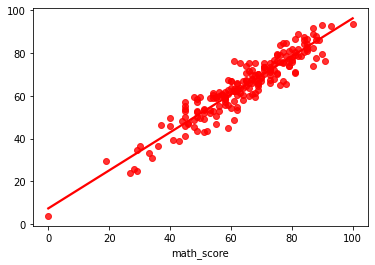

In [24]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')

### Compare predicted and actual values

In [25]:
df_pred = pd.DataFrame({"Actual":y_test,"Predicted":y_pred,"Difference":y_test-y_pred})

In [27]:
df_pred.head(20)

,Actual,Predicted,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
678,81,79.014024,1.985976
626,69,64.654609,4.345391
513,54,53.007919,0.992081
859,87,74.184710,12.815290
136,51,49.213538,1.786462
